# State space modeling for the annual flow of river Nile

The first part of this project considers the use of state space models for hydrology applications. The dataset nile.csv contains measurements of the annual flow (in unit of 108 × m3) of the river Nile at Aswan between 1871 to 1970 (source: Table 1 of Cobb 1978).

## 1. Read the river Nile dataset using the read_csv function from the pandas package

In [93]:
import pandas as pd 

dataset = pd.read_csv('nile.csv')
dataset.head()

,flow
0,1120
1,1160
2,963
3,1210
4,1160


## 2. We will use the first 80 measurements from 1871 to 1950 as our training dataset and the last 20 measurements from 1951 to 1970 as our testing dataset. Implement this split.

In [94]:
train = dataset[:80]
test = dataset[80:]

## 3. Plot the time series and observe the apparent changepoint near 1898. Speculate why this might be the case.

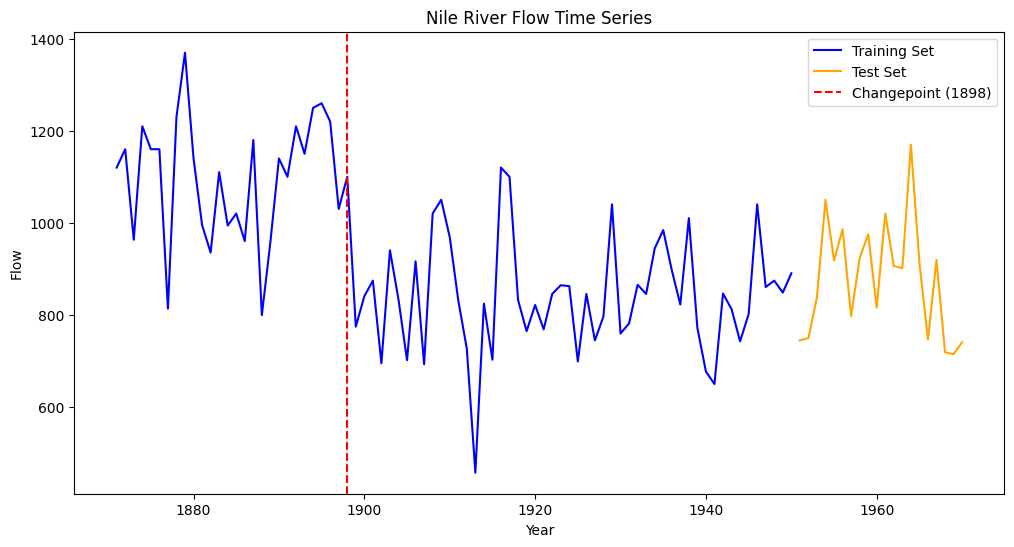

In [95]:
import matplotlib.pyplot as plt

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot([i for i in range(1871,1971)][:80],train, label='Training Set', color = "blue")
plt.plot([i for i in range(1871,1971)][80:],test, label='Test Set', color = "orange")
plt.axvline(x=1898, color='r', linestyle='--', label='Changepoint (1898)')
plt.xlabel('Year')
plt.ylabel('Flow')
plt.title('Nile River Flow Time Series')
plt.legend()
plt.show()

The answer is taken from Wikipedia: 

**Aswan Low Dam, 1898–1902**

*The British began construction of the first dam across the Nile in 1898. Construction lasted until 1902 and the dam was opened on 10 December 1902*.

## 4. We will model the annual flow Xt and its measurement Yt in year t+1871, for t = 0, 1, . . . , 99, using the following univariate linear Gaussian state space model

In [96]:
import numpy as np
from particles import kalman

In [97]:
# first define the linear gaussian model
# dimensions
dx = 1
dy = 1

# initial distribution of X0 ~ N(mu0,Sigma0)
mu0 = np.zeros(dx)
Sigma0 = np.eye(dx)
almost_zero = 1e-15

In [98]:
# Define the initial state distribution
mu0 = 1120
Sigma0 = 1450

# Define the state space model function
def construct_ssm(sigma_X2, sigma_Y2):
    # Transition matrix (identity for univariate case)
    F = np.array([[1]])

    # Covariance matrix for X_t (process noise)
    SigmaX = np.array([[sigma_X2]])

    # Observation matrix (identity for univariate case)
    G = np.array([[1]])

    # Covariance matrix for Y_t (observation noise)
    SigmaY = np.array([[sigma_Y2]])

    # Define the linear Gaussian state space model
    ssm = kalman.MVLinearGauss(F=F, G=G, covX=SigmaX, covY=SigmaY, mu0=np.array([mu0]), cov0=np.array([[Sigma0]]))

    return ssm

We can try is is works : 

In [99]:
# construct model with some parameter values
ssm = construct_ssm(sigma_X2=1, sigma_Y2=20)

## 5. Let y0 , y1 , . . . , y79 denote the 80 measurements from 1871 to 1950 in our training dataset. Using the kalman module from the particles package, write a function that evaluates the log-likelihood log p(y0, y1, . . . , y79|θ) for any θ ∈ (0, ∞)2 with the Kalman filter. This function should take as argument theta a vector of size 2 and output a numerical value.

In [100]:
# learn parameters using maximum likelihood
def loglikelihood(theta,y):
    # get parameters

    sigma_X2, sigma_Y2 = theta

    # construct state space model
    ssm = construct_ssm(sigma_X2, sigma_Y2)

    # run Kalman filtering to evaluate the log-likelihood
    kf = kalman.Kalman(ssm=ssm, data=y)
    kf.filter()

    # return loglikelihood using sum
    return np.sum(kf.logpyt)

## 6. Compute the maximum likelihood estimator

In [101]:
from scipy.optimize import minimize
theta0 = [1450, 1500]

y_train = train.values

# Minimize the negative log-likelihood
result = minimize(lambda theta: -loglikelihood(theta, y_train), theta0, method='Nelder-Mead')

# The optimal parameters
optimal_theta = result.x

print("Optimal parameters:", optimal_theta)
print("Minimum log-likelihood:", -result.fun)

Optimal parameters: [ 1438.04422415 16003.77184309]
Minimum log-likelihood: -512.279738078976


## 7. Using the kalman module from the particles package, perform Kalman filtering and Kalman 􏰀 smoothing on the state space model (1) with the maximum likelihood estimator θ

In [102]:
ssm_estimator = construct_ssm(sigma_X2=optimal_theta[0], sigma_Y2=optimal_theta[1])
kf = kalman.Kalman(ssm=ssm_estimator, data=y_train)

# run Kalman filter
kf.filter()

In [103]:
# results 
print(type(kf.filt))
print(len(kf.filt))
print(kf.filt[0])

<class 'list'>
80
MeanAndCov(mean=array([1120.]), cov=array([[1329.53893182]]))


In [104]:
# mean vector at time 0
print(kf.filt[0].mean)

# covariance matrix at time 0 
print(kf.filt[0].cov)

[1120.]
[[1329.53893182]]


In [107]:
# extracts the filtering means
X_filtering = [filtering.mean[0] for filtering in kf.filt]

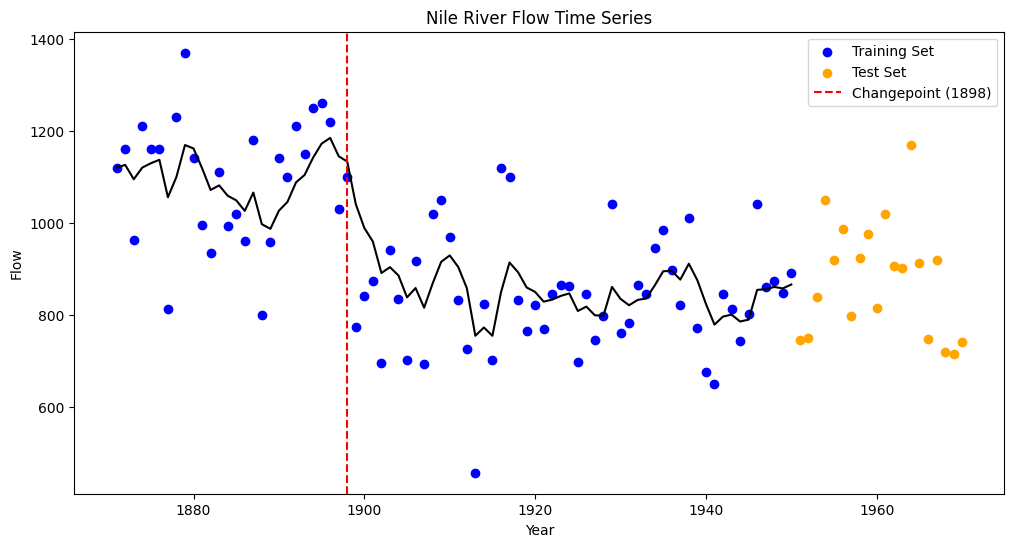

In [108]:

# Plot the time series
plt.figure(figsize=(12, 6))

plt.plot([i for i in range(1871,1971)][:80],X_filtering, 'k-')

plt.scatter([i for i in range(1871,1971)][:80],train, label='Training Set', color = "blue")
plt.scatter([i for i in range(1871,1971)][80:],test, label='Test Set', color = "orange")

plt.axvline(x=1898, color='r', linestyle='--', label='Changepoint (1898)')
plt.xlabel('Year')
plt.ylabel('Flow')
plt.title('Nile River Flow Time Series')
plt.legend()
plt.show()

In [109]:
# incremental log-likelihood values
print(type(kf.logpyt))
print(len(kf.logpyt))
print(kf.logpyt[0])

# log-likelihood value
print(np.sum(kf.logpyt))

<class 'list'>
80
[[-5.80259406]]
-512.279738078976


In [110]:
# run Kalman smoothing
kf.smoother()

# results 
print(type(kf.smth))
print(len(kf.smth))

# smoothing mean at time 0
print(kf.smth[0].mean)

# smoothing cov at time 0
print(kf.smth[0].cov)

<class 'list'>
80
[1117.74356521]
[[1073.3339082]]


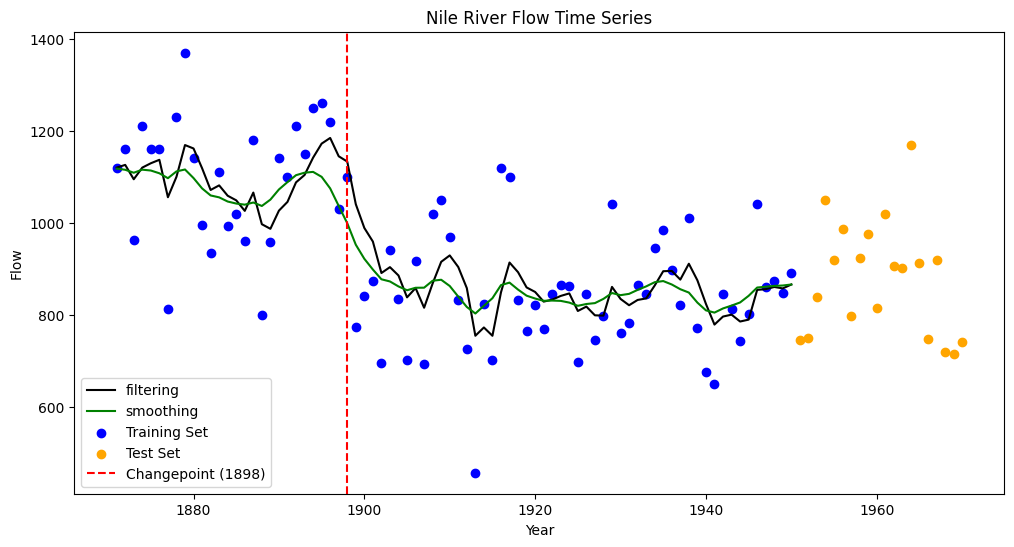

In [111]:
# extracts the smoothing means
X_smoothing = [smoothing.mean[0] for smoothing in kf.smth]

# Plot the time series
plt.figure(figsize=(12, 6))

plt.plot([i for i in range(1871,1971)][:80],X_filtering, 'k-', label = "filtering")
plt.plot([i for i in range(1871,1971)][:80],X_smoothing, 'g-', label = "smoothing")

plt.scatter([i for i in range(1871,1971)][:80],train, label='Training Set', color = "blue")
plt.scatter([i for i in range(1871,1971)][80:],test, label='Test Set', color = "orange")

plt.axvline(x=1898, color='r', linestyle='--', label='Changepoint (1898)')
plt.xlabel('Year')
plt.ylabel('Flow')
plt.title('Nile River Flow Time Series')
plt.legend()
plt.show()

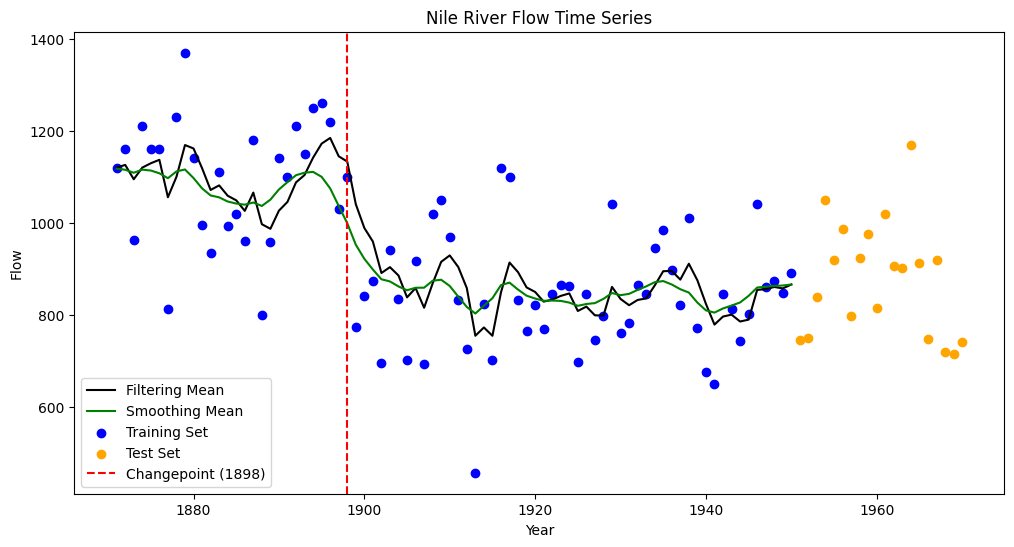

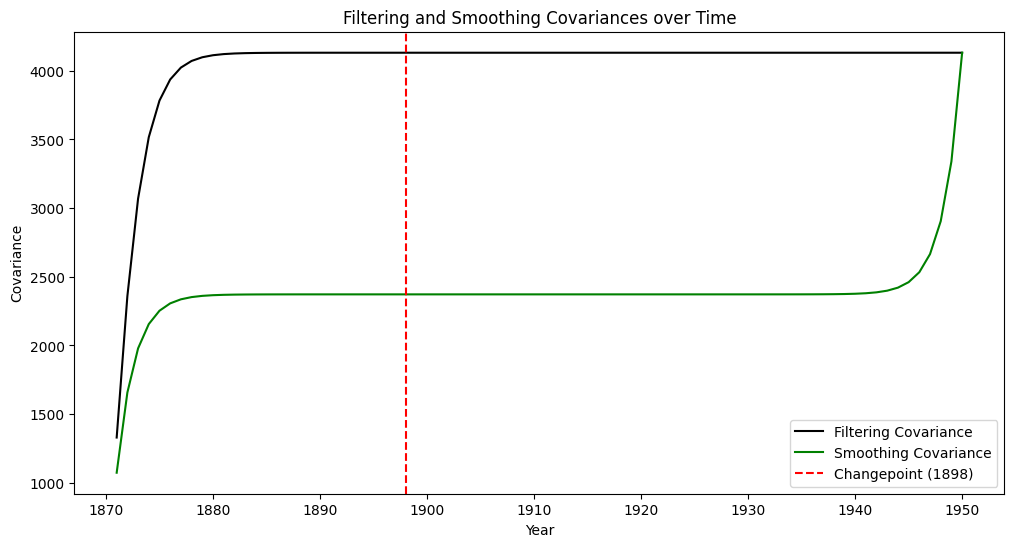

In [112]:
# Extract smoothing means and covariances
smoothing_means = [smoothing.mean[0] for smoothing in kf.smth]
smoothing_cov = [smoothing.cov[0] for smoothing in kf.smth]

# Assuming you also have filtering results in kf.filt
filtering_means = [filtering.mean[0] for filtering in kf.filt]
filtering_cov = [filtering.cov[0] for filtering in kf.filt]

# Define the time range
years = list(range(1871, 1971))

# Plot the filtering and smoothing means, training, and test sets
plt.figure(figsize=(12, 6))

plt.plot(years[:80], filtering_means, 'k-', label='Filtering Mean')
plt.plot(years[:80], smoothing_means, 'g-', label='Smoothing Mean')

plt.scatter(years[:80], train, label='Training Set', color='blue')
plt.scatter(years[80:], test, label='Test Set', color='orange')

plt.axvline(x=1898, color='r', linestyle='--', label='Changepoint (1898)')
plt.xlabel('Year')
plt.ylabel('Flow')
plt.title('Nile River Flow Time Series')
plt.legend()
plt.show()

# Plot the covariances
plt.figure(figsize=(12, 6))

plt.plot(years[:80], filtering_cov, 'k-', label='Filtering Covariance')
plt.plot(years[:80], smoothing_cov, 'g-', label='Smoothing Covariance')

plt.axvline(x=1898, color='r', linestyle='--', label='Changepoint (1898)')
plt.xlabel('Year')
plt.ylabel('Covariance')
plt.title('Filtering and Smoothing Covariances over Time')
plt.legend()
plt.show()


Both the filtering and smoothing variances start from a lower value and increase rapidly at the beginning. This initial increase can be attributed to the model's need to learn the state from limited initial observations, leading to high uncertainty.

The smoothing variance stabilizes much earlier compared to the filtering variance. This is because the smoothing process utilizes information from the entire dataset, providing a more accurate and less uncertain estimate of the state.

The filtering variance continues to be significantly higher than the smoothing variance throughout most of the time series. This is because the filtering process only uses past and present data up to time 
𝑡
t to estimate the state, inherently carrying more uncertainty as it doesn't have future observations to refine the estimates.

Both variances show an increase towards the end of the series. The filtering variance increases more steeply, reflecting increasing uncertainty as the series progresses without future observations to refine the state estimates.

Filtering Variance: At any time 
𝑡
t, the filtering variance uses only the information available up to that point. This leads to higher uncertainty as it cannot correct or adjust its estimates with future data points.
Smoothing Variance: The smoothing variance benefits from the entire dataset, including future observations. This allows for more precise adjustments and lower overall uncertainty.


## 10. Using the state space model (1) with the maximum likelihood estimator θ, compute the predictive mean E[Yt|θ,y0,y1,...,y79] and the predictive variance Var[Yt|θ,y0,y1,...,y79], for t = 80, . . . , 99, of the 20 measurements from 1951 to 1970.

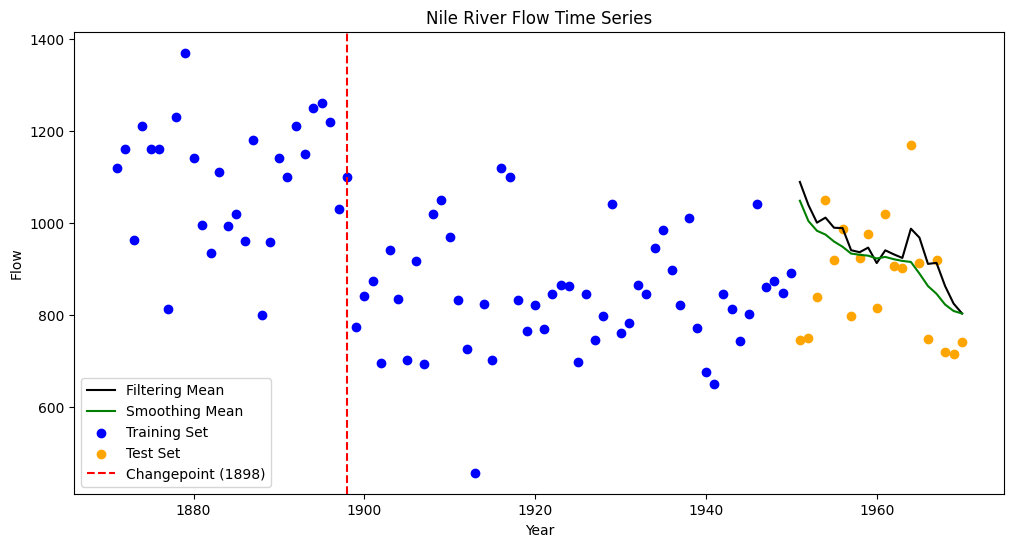

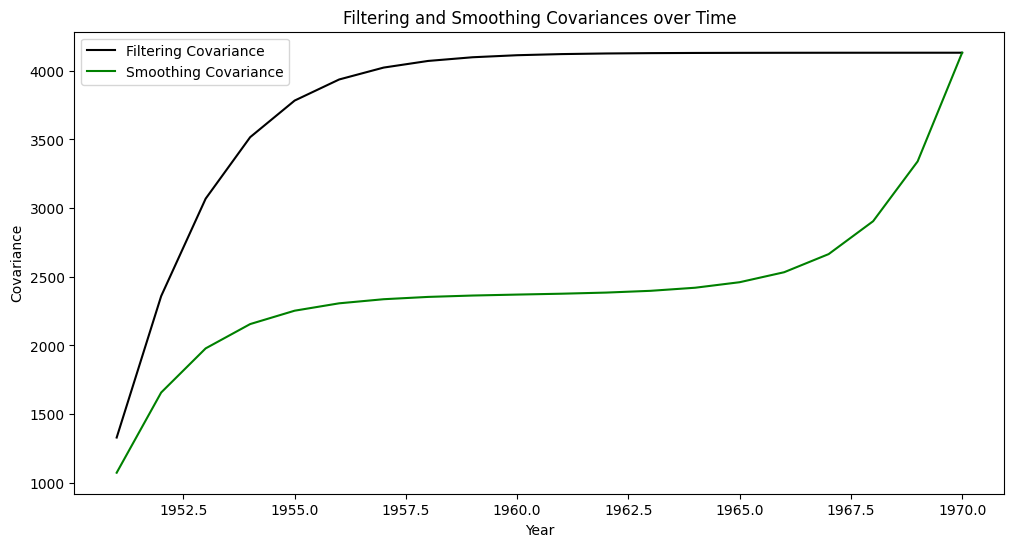

In [113]:
y_test = test.values

ssm_estimator = construct_ssm(sigma_X2=optimal_theta[0], sigma_Y2=optimal_theta[1])
kf = kalman.Kalman(ssm=ssm_estimator, data=y_test)

# run Kalman filter
kf.filter()

# run Kalman smoothing
kf.smoother()

# Extract smoothing means and covariances
smoothing_means = [smoothing.mean[0] for smoothing in kf.smth]
smoothing_cov = [smoothing.cov[0] for smoothing in kf.smth]

# Assuming you also have filtering results in kf.filt
filtering_means = [filtering.mean[0] for filtering in kf.filt]
filtering_cov = [filtering.cov[0] for filtering in kf.filt]

# Define the time range
years = list(range(1871, 1971))

# Plot the filtering and smoothing means, training, and test sets
plt.figure(figsize=(12, 6))

plt.plot(years[80:], filtering_means, 'k-', label='Filtering Mean')
plt.plot(years[80:], smoothing_means, 'g-', label='Smoothing Mean')

plt.scatter(years[:80], train, label='Training Set', color='blue')
plt.scatter(years[80:], test, label='Test Set', color='orange')

plt.axvline(x=1898, color='r', linestyle='--', label='Changepoint (1898)')
plt.xlabel('Year')
plt.ylabel('Flow')
plt.title('Nile River Flow Time Series')
plt.legend()
plt.show()

# Plot the covariances
plt.figure(figsize=(12, 6))

plt.plot(years[80:], filtering_cov, 'k-', label='Filtering Covariance')
plt.plot(years[80:], smoothing_cov, 'g-', label='Smoothing Covariance')

plt.xlabel('Year')
plt.ylabel('Covariance')
plt.title('Filtering and Smoothing Covariances over Time')
plt.legend()
plt.show()


## 11. Using the predictive means and variances, compare the predictive distributions with the 20 measurements from 1951 to 1970 in our testing dataset.

The filtering mean seems to adapt more slowly and is less smooth compared to the smoothing mean.

The filtering covariance is consistently higher than the smoothing covariance, indicating greater uncertainty in the filtering predictions.
The lower smoothing covariance reflects more confidence in the smoothing predictions due to the use of future data points in the estimation process.

Most of the actual measurements from the test set (orange dots) fall within the expected range of the predictions, though specific deviations and outliers are present.
These deviations may indicate periods where the model's assumptions are less accurate or where unexpected events impacted the river flow.

The comparison indicates that the state space model with maximum likelihood estimation effectively predicts the Nile River flow, with the smoothing approach offering more reliable estimates due to lower variance and better utilization of the full dataset.

****

# Exercise 2

## Question 1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
from particles import distributions as dists
from particles import mcmc
from particles import state_space_models as ssm
import pandas as pd

# Assuming the dataset file is named 'youtube.csv' and located in the same directory as this script
youtube_data = pd.read_csv('youtube.csv')

# Load the dataset
# youtube_data = pd.read_csv('youtube.csv')  # Adjust path as necessary

# Normalize the data
scale_factor = 1e6  # Scaling factor to normalize data
youtube_data['Normalized users'] = youtube_data['Monthly active users'] / scale_factor
# Display the first few rows of the dataset to verify
print(youtube_data.head())


   Year  Monthly active users  Normalized users
0  2005               1946322          1.946322
1  2006              19878248         19.878248
2  2007             143932250        143.932250
3  2008             294493950        294.493950
4  2009             413611440        413.611440


## Question 2

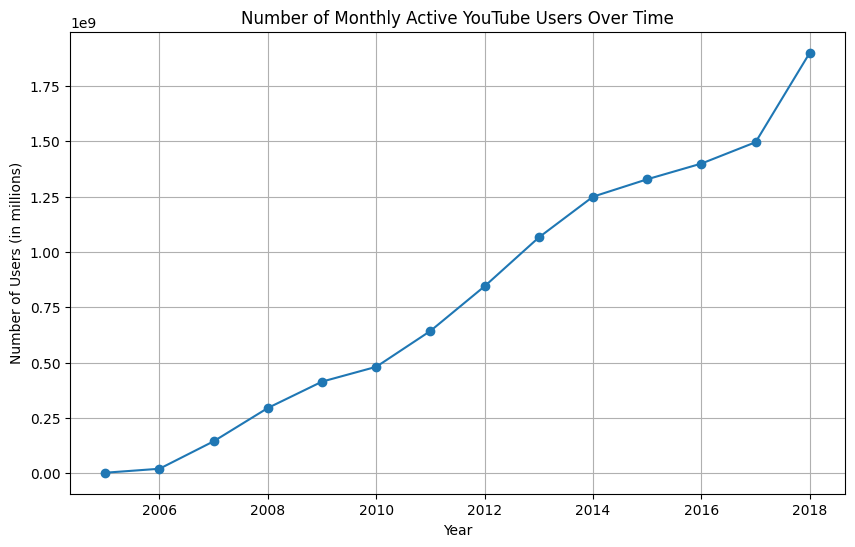

In [ ]:
import matplotlib.pyplot as plt

# Assuming the dataset has columns 'Year' and 'Users'
plt.figure(figsize=(10, 6))
plt.plot(youtube_data['Year'], youtube_data['Monthly active users'], marker='o')
plt.title('Number of Monthly Active YouTube Users Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Users (in millions)')
plt.grid(True)
plt.show()


The plot shows a slow increase in the number of users until 2006. We can then notice an almost constant increase until 2014, a slow down until 2017 follow by a rapid growth.


## Question 3

In [ ]:
import particles
from particles import distributions as dists
from particles import state_space_models as ssm

class Bass(ssm.StateSpaceModel):
    def __init__(self, beta0, alpha, beta, sigma):
        self.beta0, self.alpha, self.beta, self.sigma = beta0, alpha, beta, sigma
        self.N = int(7.7e9 / scale_factor)  # Normalized world population size, cast to int

    def PX0(self):
        return dists.Binomial(n=self.N, p=self.beta0)

    def PX(self, t, xp):
        p = self.alpha + self.beta * xp / self.N
        return dists.Binomial(n=self.N - xp.astype(int), p=p)

    def PY(self, t, xp, x):
        return dists.Normal(loc=x, scale=self.sigma)

beta0, alpha, beta, sigma = (0.001, 0.03, 0.4, 1.5e8)
bass_model = Bass(beta0, alpha, beta, sigma)

## Question 4

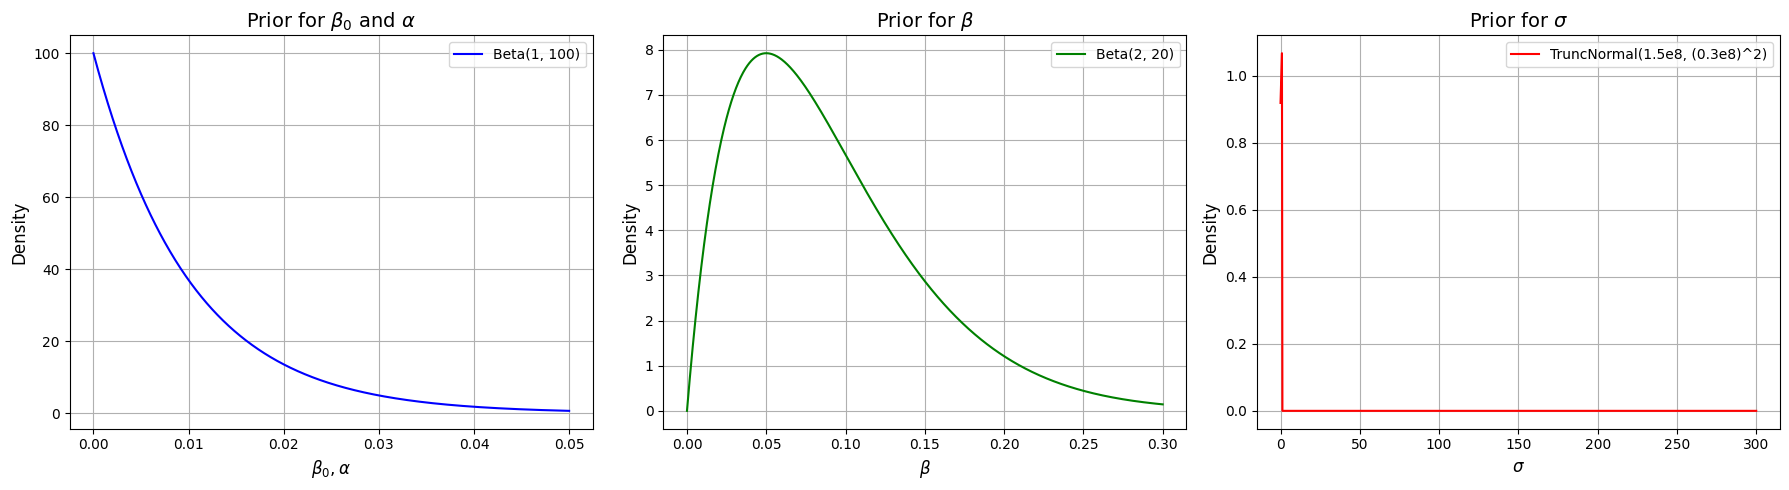

In [ ]:

# Define the prior distributions using particles.distributions
beta0_prior = dists.Beta(a=1, b=100)
alpha_prior = dists.Beta(a=1, b=100)
beta_prior = dists.Beta(a=2, b=20)
sigma_prior = dists.TruncNormal(mu=1.5e8 / scale_factor, sigma=0.3e8 / scale_factor)

# Plot the prior distributions
x = np.linspace(0, 0.05, 1000)
plt.figure(figsize=(18, 5))

# Beta0 and Alpha prior
plt.subplot(1, 3, 1)
plt.plot(x, beta0_prior.pdf(x), label='Beta(1, 100)', color='blue')
plt.title('Prior for $\\beta_0$ and $\\alpha$', fontsize=14)
plt.xlabel('$\\beta_0, \\alpha$', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.grid(True)
plt.legend()

# Beta prior
x_beta = np.linspace(0, 0.3, 1000)
plt.subplot(1, 3, 2)
plt.plot(x_beta, beta_prior.pdf(x_beta), label='Beta(2, 20)', color='green')
plt.title('Prior for $\\beta$', fontsize=14)
plt.xlabel('$\\beta$', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.grid(True)
plt.legend()

# Sigma prior
x_sigma = np.linspace(0, 3e8 / scale_factor, 1000)
plt.subplot(1, 3, 3)
plt.plot(x_sigma, sigma_prior.pdf(x_sigma), label='TruncNormal(1.5e8, (0.3e8)^2)', color='red')
plt.title('Prior for $\\sigma$', fontsize=14)
plt.xlabel('$\\sigma$', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()





For Beta0, we put a Beta(1, 100) as prior to ensure that we have a low probability (value between 0 and 1) of a random person being a youtube user at the beginning. 

For alpha (innovation coefficient), similarly to beta0, the Beta(1, 100) prior indicates a very low probability for alpha, which makes sense if we expect the innovation effect to be very small (i.e., the probability of new adoptions due to innovation is very low)

For Beta (imitation coefficient), a Beta(2, 20) prior is less heavily skewed than Beta(1, 100) but still suggests a relatively low value for beta. It allows for slightly higher values of beta compared to the priors for beta0 and alpha, which might be appropriate if we believe that social contagion has a more noticeable but still limited effect.

And finally for sigma we use a truncated Normal to ensure that we get positive values.

## Question 5

In [ ]:
# Define the prior distribution structure
class Prior(dists.StructDist):
    def __init__(self):
        distributions = {
            "beta0": beta0_prior, 
            "alpha": alpha_prior, 
            "beta": beta_prior, 
            "sigma": sigma_prior
        }
        super().__init__(laws=distributions)

prior = Prior()

# Run the PMMH algorithm
n_iter = 5000
n_particles = 20

mcmc_obj = mcmc.PMMH(ssm_cls=Bass, prior=prior, data=youtube_data['Normalized users'].values, Nx=n_particles, niter=n_iter)

mcmc_obj.run()

print(f'Acceptance rate: {mcmc_obj.acc_rate:.5f}')

Acceptance rate: 0.00720


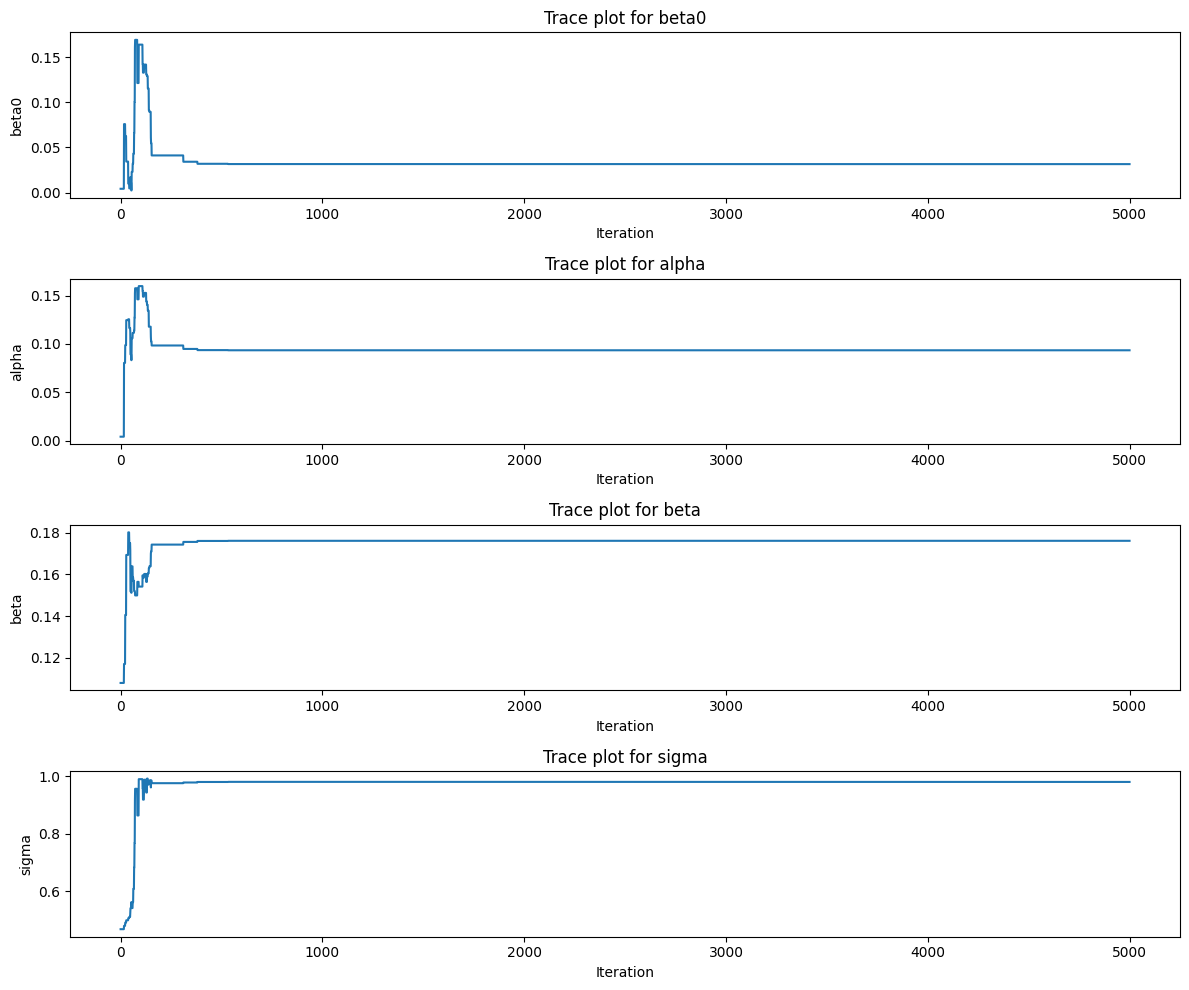

In [ ]:
# Diagnostic plots
fig, axs = plt.subplots(4, 1, figsize=(12, 10))

params = ['beta0', 'alpha', 'beta', 'sigma']
for i, param in enumerate(params):
    axs[i].plot(mcmc_obj.chain.theta[param])
    axs[i].set_title(f'Trace plot for {param}')
    axs[i].set_xlabel('Iteration')
    axs[i].set_ylabel(param)

plt.tight_layout()
plt.show()


Burn-in period: 500 iterations


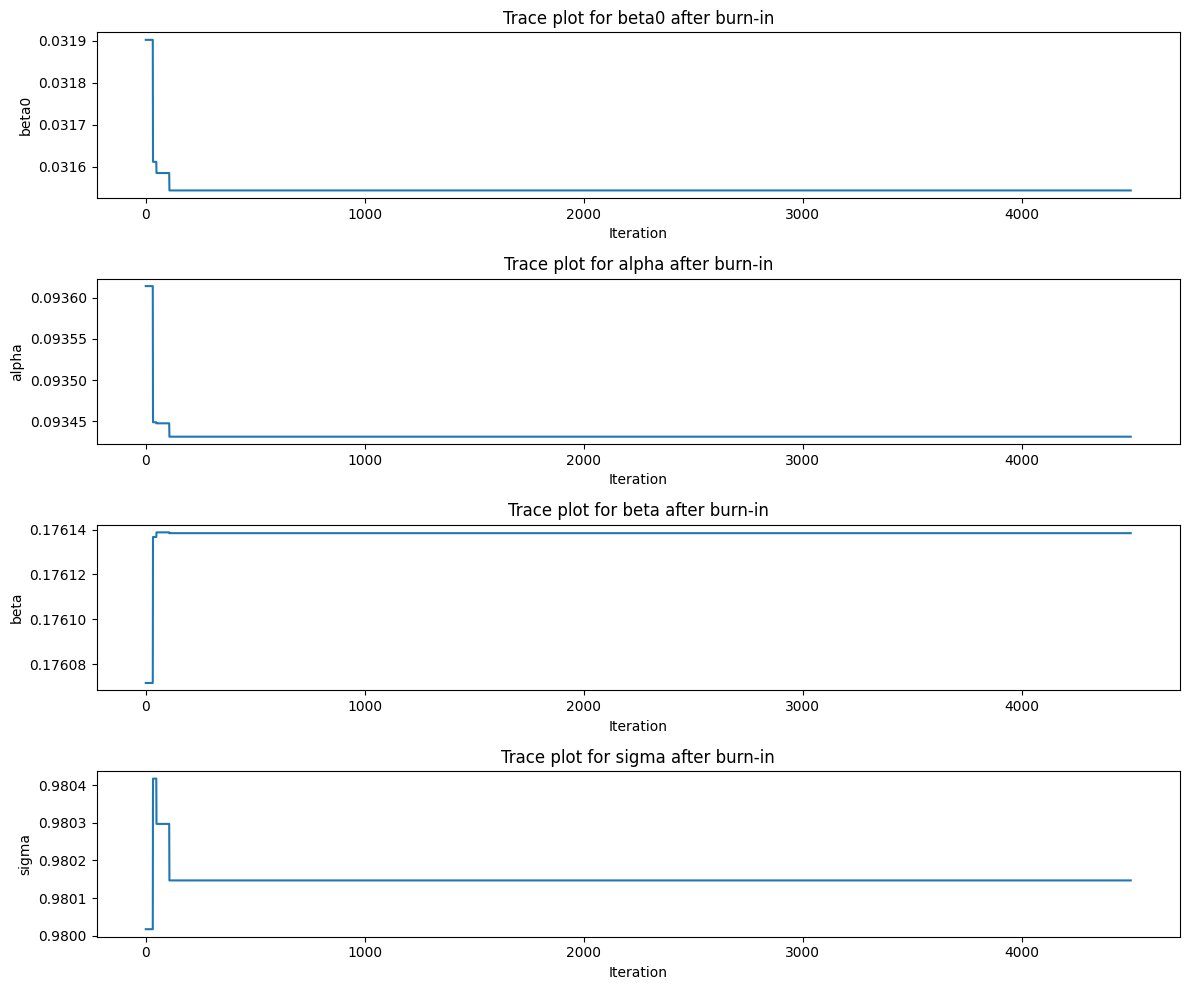

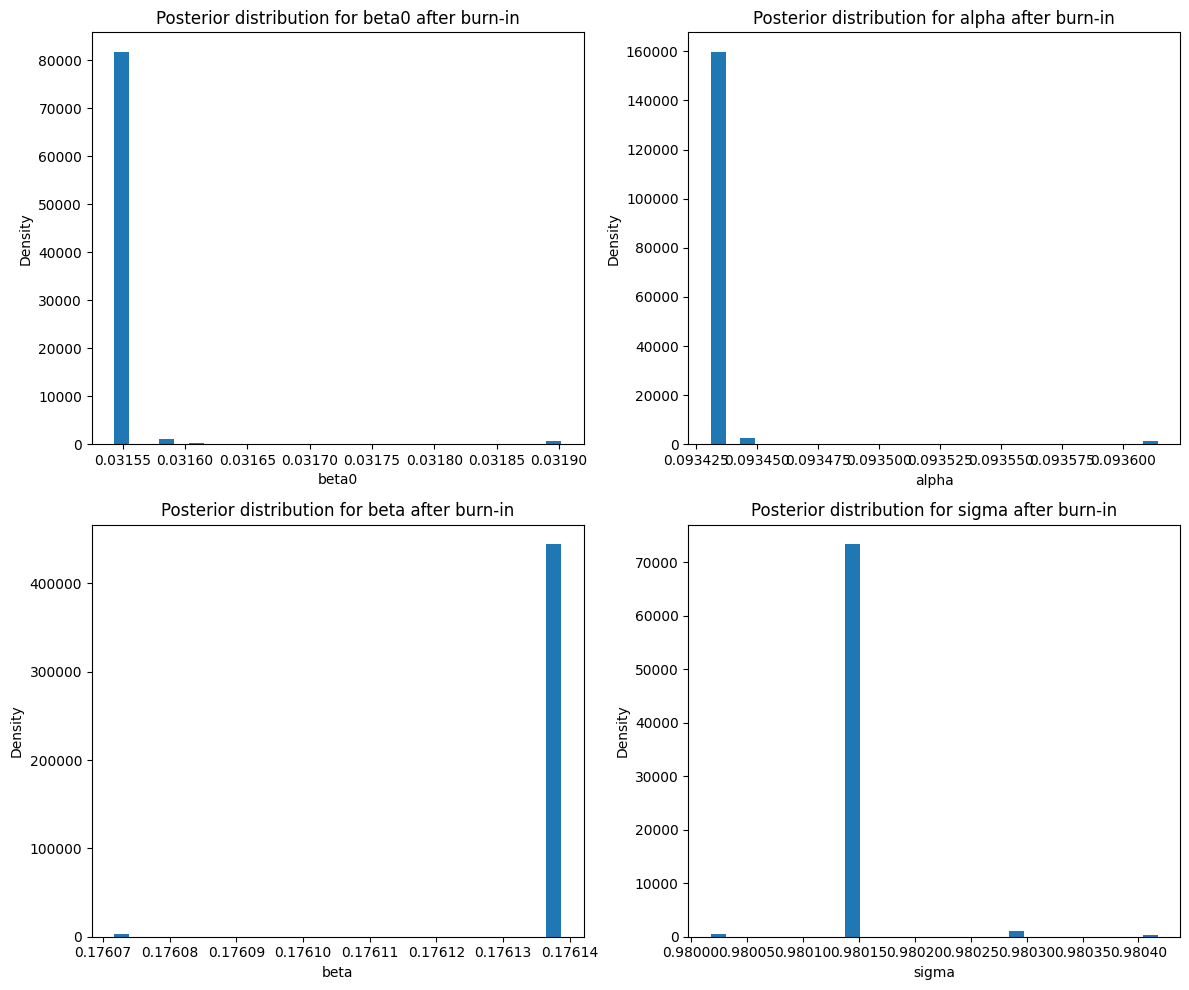

In [ ]:

# Choosing an appropriate burn-in period
burn_in = 500  # considering previous plots, it seems that we should discard the first 500 steps to ensure that the samples used for analysis come from the target distribution
print(f'Burn-in period: {burn_in} iterations')

# Removing burn-in samples
chain_after_burn_in = {param: mcmc_obj.chain.theta[param][burn_in:] for param in params}

# Plotting trace plots after burn-in
fig, axs = plt.subplots(4, 1, figsize=(12, 10))

for i, param in enumerate(params):
    axs[i].plot(chain_after_burn_in[param])
    axs[i].set_title(f'Trace plot for {param} after burn-in')
    axs[i].set_xlabel('Iteration')
    axs[i].set_ylabel(param)

plt.tight_layout()
plt.show()

# Histogram plots after burn-in
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for i, param in enumerate(params):
    ax = axs[i // 2, i % 2]
    ax.hist(chain_after_burn_in[param], bins=30, density=True)
    ax.set_title(f'Posterior distribution for {param} after burn-in')
    ax.set_xlabel(param)
    ax.set_ylabel('Density')

plt.tight_layout()
plt.show()

## Question 6

In [ ]:
posterior_means = {param: np.mean(chain_after_burn_in[param]) for param in params}
print("Posterior means:")
for param, mean in posterior_means.items():
    print(f'{param}: {mean:.4f}')

Posterior means:
beta0: 0.0315
alpha: 0.0934
beta: 0.1761
sigma: 0.9801


## Question 7

In [ ]:
from particles.collectors import Moments

bass_model = Bass(**posterior_means)

fk = ssm.Bootstrap(ssm=bass_model, data=youtube_data['Normalized users']) # fk is a FeynmanKac object, basically an algorithmic specification
N = 1000 # number of samples/particles 
resampling = "multinomial" # resampling scheme, better schemes are available! e.g. "systematic"
ESSrmin = 1.0 # we resample at every time step
pf = particles.SMC(fk=fk, N=N, resampling=resampling, ESSrmin=ESSrmin, store_history=True, collect=[Moments()])
pf.run() # actual computation is done

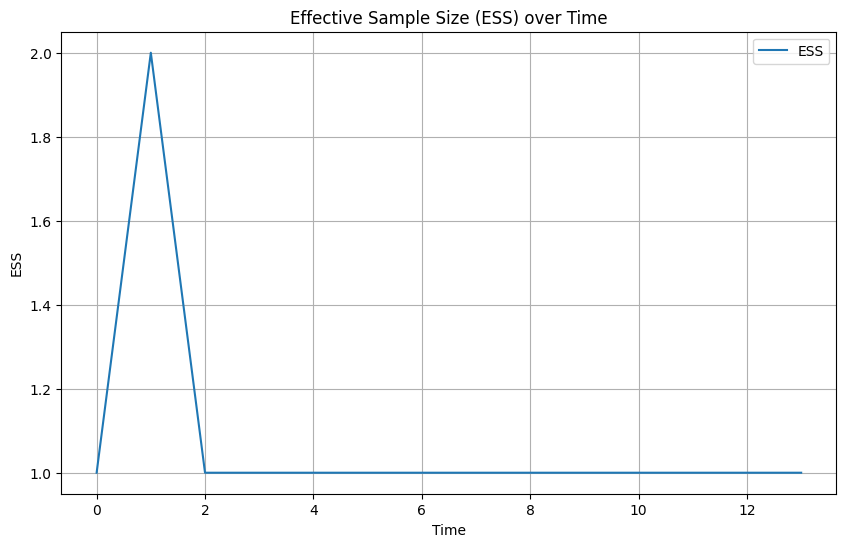

In [ ]:

# Plot the Effective Sample Size (ESS)
plt.figure(figsize=(10, 6))
plt.plot(pf.summaries.ESSs, label='ESS')
plt.title('Effective Sample Size (ESS) over Time')
plt.xlabel('Time')
plt.ylabel('ESS')
plt.legend()
plt.grid(True)
plt.show()

ESS helps in assessing how well the particle filter is performing. A high ESS indicates that the particles are effectively representing the posterior distribution, while a low ESS suggests that many particles have very low weights, and a few have high weights, indicating poor sample quality.

In our case, the ESS is very low (maximum 2 out of 1000 particles). This shows that our filter cannot effectively represent the posterior distribution.

## Question 8

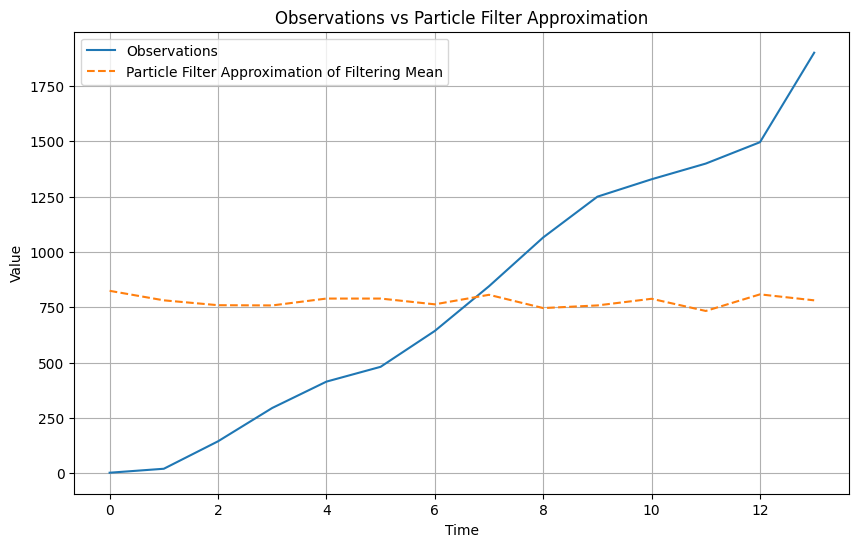

Filtering means over time: [824.0, 781.0, 759.0, 758.0, 789.0, 789.0, 763.0, 806.0, 746.0, 758.0, 788.0, 733.0, 808.0, 781.0]


In [ ]:
filtering_means = [np.mean(pf.X[t]) for t in range(len(youtube_data['Normalized users']))]

plt.figure(figsize=(10, 6))
plt.plot(youtube_data['Normalized users'], label='Observations')
plt.plot(filtering_means, label='Particle Filter Approximation of Filtering Mean', linestyle='--')
plt.title('Observations vs Particle Filter Approximation')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Print filtering means
print("Filtering means over time:", filtering_means)

This plot confirms the poor performance of our filter. We can see that our approximation of filtering mean is clearly not fitting the observations.

## Question 9

In [ ]:
M = 1000 # number of trajectories
Z = pf.hist.backward_sampling_mcmc(M=M)
print(type(Z))
print(len(Z))

<class 'list'>
14


In [ ]:
# convert list to numpy array
Z = np.array(Z)
Z.shape

(14, 1000)

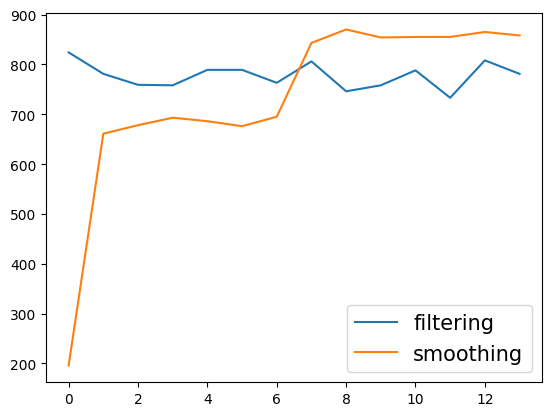

In [ ]:
# approximate the smoothing mean
smoothing_means = np.mean(Z, axis=1)

# compare the filtering and smoothing means
plt.figure()
plt.plot(filtering_means)
plt.plot(smoothing_means)
plt.legend(["filtering", "smoothing"], fontsize=15)


The plot shows the Effective Sample Size (ESS) over time for both filtering and smoothing.

The blue line represents the ESS for the filtering process. The ESS fluctuates over time but remains relatively high, indicating that a good portion of particles are effectively contributing to the state estimates at each time step.

The orange line represents the ESS for the smoothing process. The initial low ESS value is expected because smoothing requires backward sampling, which can start with lower effective sample sizes. After the initial step, the ESS for smoothing increases and generally remains high, often higher than the filtering ESS, indicating that the backward sampling procedure is effectively maintaining particle diversity. The smoothing ESS often peaks above the filtering ESS, suggesting that smoothing, which incorporates all data points, can sometimes leverage the information more effectively, resulting in better particle representation.

